# Описание проекта

Для сервиса по продажам подержанных автомобилей требуется разработать алгоритм, 
с помощью которго клиент сможет определить стоимость своего автомобиля по соответствующим характеристикам. 
Основные требования к алгоритму: минимальное время обучения, максимальная скорость обучения и качество предсказаний.


# Исходные данные

**Признаки**
* DateCrawled - дата скачивания анкеты из базы
* VehicleType - тип кузова автомобиля
* RegistrationYear - год регистрации автомобиля
* Gearbox - тип коробки передач
* Power - мощность (л.с.)
* Model - модель автомобиля
* Kilometer - пробег (км)
* RegistratlonMonth - месяц регистрации автомобиля
* FuelType - тип топлива
* Brand - марка автомобиля
* NotRepaired - была машина в ремонте или нет
* DateCreated - дата создания анкеты
* NumberOfPictures - количество фотографий автомобиля
* PostalCode - почтовый индекс владельца анкеты (пользователя)
* LastSeen - дата последней активности пользователя

**Целевой признак**
* Price - цена (евро)
___
# Содержание проекта
* 1.Подготовка данных
    - [1.1 Загрузка библиотек и исходных данных](#1.1-bullet)
    - [1.2 Предобработка данных](#1.2-bullet)
    - [1.3 Подготовка данных для обучения моделей](#1.3-bullet)
* 2.Обучение моделей
    - [2.1 Обучение модели с помощью градиентного бустинга с библиотекой CatBoost](#2.1-bullet)
    - [2.2 Обучение модели с помощью градиентного бустинга с библиотекой LightGBM](#2.2-bullet)
    - [2.3 Обучение модели с помощью решающего дерева](#2.3-bullet)
    - [2.4 Обучение модели с помощью случайного леса](#2.4-bullet)
* [3.Анализ моделей](#3-bullet)
* [4.Общие выводы](#4-bullet)


# 1. Подготовка данных

<a id='1.1-bullet'></a>
### 1.1 Загрузка библиотек и исходных данных

In [2]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import math 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
import time

In [3]:
# Сохраним исходные данные в переменной data
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# Просмотрим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<a id='1.2-bullet'></a>
### 1.2 Предобработка данных

In [5]:
# Рассмотрим целевой признак "Price" на наличие выбросов
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

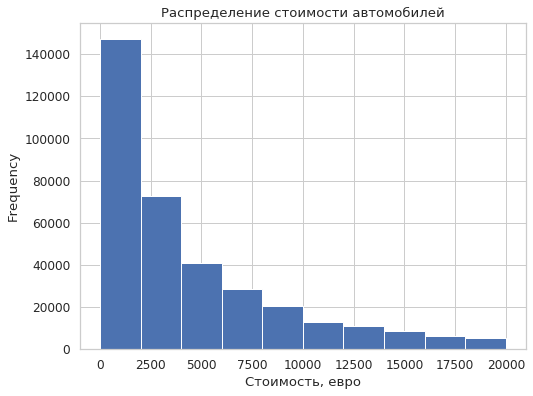

In [7]:
# Построим гистограмму распределения стоимости автомобилей
data['Price'].plot(kind='hist', figsize=(8, 6), grid=True, 
                   title='Распределение стоимости автомобилей').set_xlabel('Стоимость, евро')
sns.set(style="whitegrid", color_codes=True, font_scale = 1.1)

In [6]:
# Отбросим нижние выбросы по стоимости (отбросим 10% по нижней границе стоимости)
low_price = data['Price'].quantile(0.10)
data_filtr_1 = data[data['Price'] > low_price]
data_filtr_1['Price'].describe()

count    318315.000000
mean       4895.083204
std        4520.261286
min         500.000000
25%        1499.000000
50%        3200.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

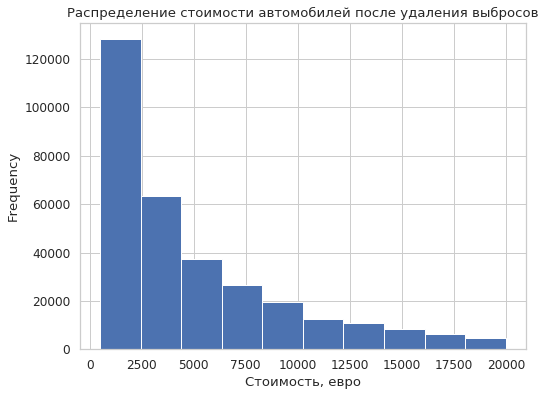

In [7]:
# Построим гистограмму распределения стоимости автомобилей после удаления выбросов по нижней границе стоимости 
data_filtr_1['Price'].plot(kind='hist', figsize=(8, 6), grid=True, 
                           title='Распределение стоимости автомобилей после удаления выбросов').set_xlabel('Стоимость, евро')
sns.set(style="whitegrid", color_codes=True, font_scale = 1.1)

In [8]:
# Рассмотрим признак "VehicleType"
data_filtr_1['VehicleType'].value_counts()

sedan          85475
small          68289
wagon          60740
bus            27835
convertible    19549
coupe          14844
suv            11715
other           2774
Name: VehicleType, dtype: int64

In [9]:
# Просмотрим пропуски в столбце "VehicleType"
data_filtr_1[data_filtr_1['VehicleType'].isnull()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44


In [10]:
# Заменим пропуски в столбце "VehicleType" на "other" (т.к. исходных данных не достаточно для определения по ним типа кузова)
data_filtr_1['VehicleType'] = data_filtr_1['VehicleType'].fillna('other')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# Проверим все ли пропуски были заполнены
data_filtr_1['VehicleType'].isnull().sum()

0

In [12]:
# Рассмотрим признак "Model"
data_filtr_1['Model'].isnull().sum()

14681

In [13]:
# Просмотрим строки с пропусками в столбце "Model"
data_filtr_1[data_filtr_1['Model'].isnull()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
161,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28 00:00:00,0,99086,2016-04-04 11:45:46


In [14]:
# Удалим строки с пропусками в столбце "Model"
data_filtr_1 = data_filtr_1.dropna(subset=['Model'])   #, inplace=True)
data_filtr_1['Model'].isnull().sum()

0

In [15]:
# Рассмотрим признак "RegistrationYear"
data_filtr_1['RegistrationYear'].unique() 

array([2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 2007, 2009, 2002,
       2018, 1990, 2017, 1981, 2003, 2016, 1991, 1984, 2006, 1999, 2012,
       2010, 2000, 1992, 1993, 1997, 2013, 1994, 1996, 1989, 2015, 1985,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965,
       1970, 1945, 1974, 1955, 1978, 1979, 1972, 1968, 1977, 1966, 1975,
       1910, 1963, 1967, 9999, 1960, 1500, 1964, 2066, 1949, 2019, 1937,
       1951, 1959, 1953, 1954, 1958, 1956, 1962, 9000, 2900, 5911, 1400,
       5000, 1961, 4000, 1952, 8500, 1932, 1000, 1950, 3700, 1942, 1933,
       1936, 1957, 1923, 2290, 1930, 1001, 7000, 1929, 1943, 1938, 1934,
       1935, 1928, 1941, 5555, 1800, 6000, 1931, 4500, 1602, 7800, 1947,
       1927, 7100, 8200, 1600])

In [16]:
# Посмотрим кол-во автомобилей зарегестрированных ранее 1950г
(data_filtr_1['RegistrationYear'] < 1950).value_counts().head(40)

False    303571
True         63
Name: RegistrationYear, dtype: int64

In [17]:
# Уберем года больше 2019 и меньше 1950 
data_filtr_2 = data_filtr_1[(data_filtr_1['RegistrationYear'] <= 2019) & (data_filtr_1['RegistrationYear'] > 1950)]
data_filtr_2.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39


In [18]:
# Рассмотрим признак "Gearbox"
data_filtr_2['Gearbox'].isnull().sum()

11194

In [19]:
# Просмотрим пропуски в столбце Gearbox
data_filtr_2[data_filtr_2['Gearbox'].isnull()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
37,2016-03-28 17:50:15,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
94,2016-03-28 16:37:43,8390,other,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,2016-03-28 00:00:00,0,29221,2016-03-30 07:44:59
130,2016-03-20 18:47:31,3390,other,2000,NaN,0,3er,150000,2,NaN,bmw,NaN,2016-03-20 00:00:00,0,45739,2016-03-28 19:48:42
197,2016-03-08 09:56:53,3200,wagon,2006,NaN,0,a3,150000,11,gasoline,audi,no,2016-03-08 00:00:00,0,41748,2016-03-08 09:56:53


In [20]:
# Создадим ф-ию "Car_data", с помощью которой, на основании столбцов данных в столбцах 'Brand', 'Model', 'RegistrationYear',
# можно будет определить пропущенные значения для столбцов "Gearbox" и "FuelType".
# Так же внутри ф-ии добавлена еще одна ф-ия "max_colname", кот-ая выбирает в каждой строке наибольшее количество автомобилей
# и сохраняет наименование столбца для наибольшего значения в каждой строке. Этим значением и будет заполнятся пропуск
# в исходном датасете с учетом марки авто, модели и года регистрации. 
def car_data(data, col_1, col_2):
    # Для каждой модели с учетом года выпуска определим искомый параметр (Gearbox или FuelType) 
    dataset = data.pivot_table(index=['Brand', 'Model', 'RegistrationYear'], columns= col_1,     
                                                              values='PostalCode', aggfunc='count')
    # Заменим пропуски в столбцах на 0.1 для дальнейшей обработки данных
    dataset = dataset.fillna(0.1)
    # Добавим новый столбец col_2, в который запишим ниаменование столбцаов c максимальным значением по каждой строке 
    def max_colname(row, colnames):
        return colnames[np.argmax(row.values)]
    dataset[col_2] = dataset.apply(lambda x: max_colname(x, dataset.columns), axis=1)
    
    # Создадим новый датафрейм куда запишем значения индексов датасета "Dataset"
    new_row = pd.DataFrame((dataset.index).values.tolist(), columns=['Brand', 'Model', 'RegistrationYear'])
    dataset.reset_index(inplace=True, drop=True)
    # Добавим в датасет "Dataset" столбцы из датасета "new_row" 
    dataset = pd.merge(dataset, new_row, left_index=True, right_index=True)    
    dataset = dataset[['Brand', 'Model', 'RegistrationYear', col_2]]
    return dataset

# Определим тип коробки передач в зависимости от года выпуска для каждой модели авто 
gearbox_data = car_data(data_filtr_2, 'Gearbox', 'Type_of_Gearbox')
gearbox_data.head()

,Brand,Model,RegistrationYear,Type_of_Gearbox
0,alfa_romeo,145,1995,manual
1,alfa_romeo,145,1996,manual
2,alfa_romeo,145,1997,manual
3,alfa_romeo,145,1998,manual
4,alfa_romeo,145,1999,manual


In [21]:
# Проверим нет ли повторяющихся строк в датасете "Gearbox_data"
gearbox_data.duplicated().sum()

0

In [22]:
# Заполним пропуски в столбце "Gearbox" в датасете data_filtr_2 нулевыми значениям 
data_filtr_2['Gearbox'] = data_filtr_2['Gearbox'].fillna(0)
data_filtr_2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39


In [23]:
# Добавим в data_filtr_3 новый столбец "Type_of_Gearbox", с помощью которого потом будем заполнять пропуски в столбце "Gearbox" 
data_filtr_3 = data_filtr_2.copy()
data_filtr_3 = data_filtr_3.merge(gearbox_data, how='left', on=['Brand', 'Model', 'RegistrationYear'])
data_filtr_3.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual


In [24]:
# Проверим количество пропусков в столбце "Type_of_Gearbox"
data_filtr_3['Type_of_Gearbox'].isnull().sum()

139

In [25]:
# Т.к. в целом количество машин с механической коробкой в разы больше, 
# заполним оставшиеся пропуски в столбце "Type_of_Gearbox" значением "manual"
data_filtr_3['Type_of_Gearbox'] = data_filtr_3['Type_of_Gearbox'].fillna('manual')

# Проверим не осталось ли пропусков в столбце "Type_of_Gearbox"
data_filtr_3['Type_of_Gearbox'].isnull().sum()

0

In [26]:
# Создадим ф-ию "Data_fill", с помощью которой можно будет заменить пропущенные значения в одном столбце
# на значения из др. столбца датасета "data_filtr_3"
def data_fill(col_1, col_2):
    if col_1 == 0:
        return col_2
    return col_1

# С помощью ф-ии Data_fill заменим пропущенные значения в столбце "Gearbox" на значение из столбца "Type_of_Gearbox"
data_filtr_3['Gearbox'] = data_filtr_3.apply(lambda x: data_fill(x['Gearbox'], x['Type_of_Gearbox']), axis=1)
data_filtr_3.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual


In [27]:
# Сравним как изменилось количество значений "manual" и "auto" в столбце "Gearbox" до и после заполнения пропусков
print('Количество значений до заполнения пропусков в столбце "Gearbox":')
print(data_filtr_2['Gearbox'].value_counts())
print()      
print('Количество значений после заполнения пропусков в столбце "Gearbox":')
print(data_filtr_3['Gearbox'].value_counts())     

Количество значений до заполнения пропусков в столбце "Gearbox":
manual    231889
auto       60446
0          11194
Name: Gearbox, dtype: int64

Количество значений после заполнения пропусков в столбце "Gearbox":
manual    241429
auto       62100
Name: Gearbox, dtype: int64


In [28]:
# Проверим все ли пропуски в столбце "Gearbox" были заполнены
data_filtr_3['Gearbox'].isnull().sum()

0

In [29]:
# Рассмотрим признак "FuelType"
data_filtr_3['FuelType'].isnull().sum()

18709

In [30]:
# Просмотрим строки с пропусками в столбце "FuelType"
data_filtr_3[data_filtr_3['FuelType'].isnull()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox
6,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,manual
10,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54,manual
20,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46,manual
28,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09,manual
32,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,33649,2016-04-03 11:44:49,auto


In [31]:
# Переименуем тип топлива "gasoline" в "petrol", т.к. это один и тот же тип (разные называния в Англии и Америке)
data_filtr_3.loc[data_filtr_3['FuelType'] == 'gasoline','FuelType'] = 'petrol'
print(data_filtr_3['FuelType'].value_counts())     

petrol      279222
lpg           4727
cng            515
hybrid         202
other           94
electric        60
Name: FuelType, dtype: int64


In [32]:
# Определим тип топлива в зависимости от года регистрации для каждой модели авто 
fuel_type_data = car_data(data_filtr_2, 'FuelType', 'Type_of_FuelType')
fuel_type_data.head()

,Brand,Model,RegistrationYear,Type_of_FuelType
0,alfa_romeo,145,1995,petrol
1,alfa_romeo,145,1996,petrol
2,alfa_romeo,145,1997,petrol
3,alfa_romeo,145,1998,petrol
4,alfa_romeo,145,1999,petrol


In [33]:
# Проверим нет ли повторяющихся строк в датасете "FuelType_data"
fuel_type_data.duplicated().sum()

0

In [34]:
# Заполним пропуски в столбце "FuelType" в датасете data_filtr_2 нулевыми значениям 
data_filtr_3['FuelType'] = data_filtr_3['FuelType'].fillna(0)
data_filtr_3.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual


In [35]:
# Добавим в data_filtr_4 новый столбец "Type_of_FuelType", с помощью кот-го потом будем заполнять пропуски в столбце "FuelType" 
data_filtr_4 = data_filtr_3.copy()
data_filtr_4 = data_filtr_4.merge(fuel_type_data, how='left', on=['Brand', 'Model', 'RegistrationYear'])
data_filtr_4.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto,gasoline
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual,petrol
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual,petrol
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual,petrol
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual,petrol


In [36]:
# Проверим количество пропусков в столбце "Type_of_FuelType"
data_filtr_4['Type_of_FuelType'].isnull().sum()

259

In [37]:
# Т.к. в целом количество машин на бензине существенно больше, 
# заполним оставшиеся пропуски в столбце "Type_of_FuelType" значением "petrol"
data_filtr_4['Type_of_FuelType'] = data_filtr_4['Type_of_FuelType'].fillna('petrol')

# Провери не осталось ли пропусков в столбце "Type_of_FuelType"
data_filtr_4['Type_of_FuelType'].isnull().sum()

0

In [38]:
# С помощью ф-ии Data_fill заменим пропущенные значения в столбце "FuelType" на значение из столбца "Type_of_FuelType"
data_filtr_4['FuelType'] = data_filtr_4.apply(lambda x: data_fill(x['FuelType'], x['Type_of_FuelType']), axis=1)
data_filtr_4.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto,gasoline
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual,petrol
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual,petrol
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual,petrol
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual,petrol


In [39]:
# Сравним как изменилось количество значений в столбце "FuelType" до и после заполнения пропусков
print('Количество значений до заполнения пропусков в столбце "FuelType":')
print(data_filtr_2['FuelType'].value_counts())
print()      
print('Количество значений после заполнения пропусков в столбце "FuelType":')
print(data_filtr_4['FuelType'].value_counts())     

Количество значений до заполнения пропусков в столбце "FuelType":
petrol      185722
gasoline     93500
lpg           4727
cng            515
hybrid         202
other           94
electric        60
Name: FuelType, dtype: int64

Количество значений после заполнения пропусков в столбце "FuelType":
petrol      294277
lpg           4766
gasoline      3599
cng            516
hybrid         206
other          105
electric        60
Name: FuelType, dtype: int64


In [40]:
# Проверим все ли пропуски в столбце "FuelType" были заполнены
data_filtr_4['FuelType'].isnull().sum()

0

In [41]:
# Рассмотрим признак "NotRepaired"
data_filtr_4['NotRepaired'].isnull().sum()

48583

In [42]:
# Просмотрим пропуски в столбце "NotRepaired"
data_filtr_4[data_filtr_4['NotRepaired'].isnull()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto,gasoline
5,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13,manual,petrol
6,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,manual,petrol
9,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16,manual,petrol
25,2016-03-29 16:57:02,899,other,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07,manual,petrol


In [43]:
# Просмотрим данные в столбце "Power"
data_filtr_4['Power'].describe()

count    303529.000000
mean        115.652738
std         184.428513
min           0.000000
25%          75.000000
50%         109.000000
75%         145.000000
max       20000.000000
Name: Power, dtype: float64

In [44]:
# Надем среднюю мощность для каждой модели
power_value = data_filtr_4[(data_filtr_4['Power'] > 20) & (data_filtr_4['Power'] < 600)]
power_data = power_value.pivot_table(index=['Brand', 'Model'], values='Power', aggfunc='mean')
power_data.head()

Power
Brand      Model            
alfa_romeo 145    115.800000
           147    120.791749
           156    151.024540
           159    173.115000
           other  147.538293

In [45]:
# Сохраним значения индексов датасета "Power_data" в новый датасет "Power_data_index" 
power_data_index = pd.DataFrame((power_data.index).values.tolist(), columns=['Brand', 'Model'])
power_data_index.head()

,Brand,Model
0,alfa_romeo,145
1,alfa_romeo,147
2,alfa_romeo,156
3,alfa_romeo,159
4,alfa_romeo,other


In [46]:
# Добавим в датасет "Power_data" столбцы из датасета "Power_data_index"
power_data.reset_index(inplace=True, drop=True)
power_data = pd.merge(power_data, power_data_index, left_index=True, right_index=True)
power_data['Power'] = power_data['Power'].astype(int)
power_data.columns = ['Mean_Power','Brand', 'Model']
power_data.head()

,Mean_Power,Brand,Model
0,115,alfa_romeo,145
1,120,alfa_romeo,147
2,151,alfa_romeo,156
3,173,alfa_romeo,159
4,147,alfa_romeo,other


In [47]:
# Добавим в "data_filtr_4" новый столбец "Mean_Power", с помощью кот-го потом заполним некорректные значения в столбце "Power" 
data_filtr_5 = data_filtr_4.copy()
data_filtr_5 = data_filtr_5.merge(power_data, how='left', on=['Brand', 'Model'])
data_filtr_5.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType,Mean_Power
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto,gasoline,206.0
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual,petrol,106.0
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual,petrol,79.0
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual,petrol,153.0
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual,petrol,94.0


In [48]:
# Создадим новый столбец со средними значениями мощности для каждой модели
def power_fill(data):
    if data['Power'] <= 20:
        return data['Mean_Power']
    if data['Power'] >= 600:
        return data['Mean_Power']
    return data['Power']

data_filtr_5['Power'] = data_filtr_5.apply(power_fill, axis=1)
data_filtr_5.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType,Mean_Power
0,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto,gasoline,206.0
1,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual,petrol,106.0
2,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual,petrol,79.0
3,2016-04-04 17:36:23,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual,petrol,153.0
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109.0,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual,petrol,94.0


In [49]:
# Проверим все ли столбцы корректно заполнились
data_filtr_5['Power'].isnull().sum()

1

In [50]:
# Т.к. модель "serie_1" в датасете в одном экземпляре, заменим NAN на среднее значение мощности для марки "land_rover" 
data_filtr_5[data_filtr_5['Power'].isnull()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType,Mean_Power
200425,2016-03-30 11:39:08,3800,wagon,1978,manual,NaN,serie_1,30000,0,petrol,land_rover,NaN,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08,manual,gasoline,NaN


In [51]:
# Найдем среднее значение мощности для марки "land_rover" 
land_rover = data_filtr_5[data_filtr_5['Brand'] == 'land_rover']
land_rover_power = land_rover['Power'].mean().astype(int)
print('Средняя мощность для марки land_rover: ', land_rover_power)

Средняя мощность для марки land_rover:  150


In [52]:
# Заменим значение NAN в столбце "Power" на среднее значение для 'land_rover' - 150
data_filtr_5['Power'] = data_filtr_5['Power'].fillna(land_rover_power)
data_filtr_5['Power'] = data_filtr_5['Power'].astype(int)
data_filtr_5[200425:].head(1)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType,Mean_Power
200425,2016-03-30 11:39:08,3800,wagon,1978,manual,150,serie_1,30000,0,petrol,land_rover,NaN,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08,manual,gasoline,NaN


In [53]:
# Просмотрим данные в столбце "NumberOfPictures" (в данном столбце все значения нулевые, оэтому при обучении его не учитываем)
data_filtr_5['NumberOfPictures'].value_counts()

0    303529
Name: NumberOfPictures, dtype: int64

In [54]:
# Просмотрим данные в столбце "Kilometer"
data_filtr_5['Kilometer'].value_counts()

150000    200777
125000     32852
100000     13179
90000      10662
80000       9330
70000       8002
60000       7001
50000       5822
40000       4592
30000       3984
20000       3323
5000        3082
10000        923
Name: Kilometer, dtype: int64

In [55]:
# Просмотрим пропуски в столбце "NotRepaired"
data_filtr_5['NotRepaired'].value_counts()

no     229950
yes     24996
Name: NotRepaired, dtype: int64

In [56]:
# Определим зависимость ремонта от года регистроции авто
not_repaired_data = data_filtr_5.pivot_table(index='RegistrationYear', columns='NotRepaired', values='PostalCode', 
                                                                                                     aggfunc='count')
# Временно заполним пропуски 0.1
not_repaired_data = not_repaired_data.fillna(0.1)
not_repaired_data.head()

NotRepaired,no,yes
RegistrationYear,,
1951,6.0,0.1
1952,3.0,0.1
1953,4.0,3.0
1954,5.0,0.1
1955,6.0,0.1


In [57]:
# Добавим ф-ию "max_value_colname" кот-ая сравнивает количество значений в двух столбцам 
# и выводит наиболтее распространенное значение в новый столбец
def max_value_colname(row, colnames):
        return colnames[np.argmax(row.values)]

# С помощью ф-ии "max_value_colname" определим наибольшее кол-во "no" или "yes" для каждого года регистрации   
not_repaired_data['max_value'] = not_repaired_data.apply(lambda x: max_value_colname(x, not_repaired_data.columns), axis=1)    
not_repaired_data.head()

NotRepaired,no,yes,max_value
RegistrationYear,,,
1951,6.0,0.1,no
1952,3.0,0.1,no
1953,4.0,3.0,no
1954,5.0,0.1,no
1955,6.0,0.1,no


In [58]:
# Просмотрим общее кол-во "yes" и "no" в столбце "max_value" 
not_repaired_data['max_value'].value_counts()

no     68
yes     1
Name: max_value, dtype: int64

In [59]:
# С учетом того что по большенству моделей авто без ремонта встречается гораздо чаще чем после ремонта, 
# заменим все пропуски на "no" 
data_filtr_5['NotRepaired'] = data_filtr_5['NotRepaired'].fillna('no')
data_filtr_5.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Type_of_Gearbox,Type_of_FuelType,Mean_Power
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto,gasoline,206.0
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual,petrol,106.0
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,manual,petrol,79.0
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,manual,petrol,153.0
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual,petrol,94.0


In [60]:
# Проверим заполнение всех пропусков в датасете
data_filtr_5.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
Type_of_Gearbox      0
Type_of_FuelType     0
Mean_Power           1
dtype: int64

<a id='1.3-bullet'></a>
### 1.3 Подготовка данных для обучения моделей

In [61]:
# Отбросим нерелевантные признаки
data_filtr_5 = data_filtr_5.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 
                                  'PostalCode', 'LastSeen', 'Type_of_Gearbox', 'Type_of_FuelType', 'Mean_Power'], axis=1)
data_filtr_5.shape

(303529, 10)

In [62]:
# Выполним порядковое кодирование с помощью OrdinalEncoder
#encoder = OrdinalEncoder()
#encoder.fit(data_filtr_5)
#data_ordinal = pd.DataFrame(encoder.fit_transform(data_filtr_5), columns=data_filtr_5.columns)
#data_ordinal.head()

In [63]:
# Сохраним целевой признак в переменную target
target = data_filtr_5['Price']
target.head()

0    9800
1    1500
2    3600
3     650
4    2200
Name: Price, dtype: int64

In [64]:
# Сохраним признаки в переменную features
features = data_filtr_5.drop('Price', axis=1)
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,suv,2004,auto,163,grand,125000,petrol,jeep,no
1,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,small,2008,manual,69,fabia,90000,petrol,skoda,no
3,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [65]:
# Разобьем выборки target и features на обучающие и тестовые подвыборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                             random_state=12345)
# Проверим размеры полученных выборок
print('Размер выборки features_train:', features_train.shape)
print('Размер выборки target_train:', target_train.shape)
print('Размер выборки features_test:', features_test.shape)
print('Размер выборки target_test:', target_test.shape)

Размер выборки features_train: (227646, 9)
Размер выборки target_train: (227646,)
Размер выборки features_test: (75883, 9)
Размер выборки target_test: (75883,)


In [66]:
# Создадим ф-ию "model_learning" для обучения моделей
def model_learning(model, f_train, t_train, f_test):
    model.fit(f_train, t_train)
    prediction = model.predict(f_test)
    return prediction

In [67]:
# Создадим ф-ию "rmse" для определения метрики RMSE
def rmse(t_test, prediction):
    mse = mean_squared_error(t_test, prediction)
    rmse = mse ** 0.5
    return rmse

### Вывод по п.1

При изучении исходных данных было выявлено следующее:
 - В столбцах **VehicleType, Gearbox, Model, FuelType, NotRepaired**;
 - В столбце **FuelType** автомобили с бензиновым двиготелем обозначены двумя разными типами **ptrol и gasoline**;
 - В столбце **Price** есть близкая к нулевой и нулевая стоимость авто; 
 - В столбце **RegistrationYear** есть выбросы по годам, как по верхней границе, больше 2019г. там и по нижней, например 1600, 1800;
 - В столбце **Power** есть выбросы как по нижней, так и верхней границе мощности.

В столбце **Price** было отброшено 10% по нижней границе стоимости автомобилей, предположим, что авто не может стоить ниже 500 евро.
В столбце **RegistrationYear** были отброшены года больше 2019 и меньше 1950 (т.к. их всего 109). 
В столбцах **Gearbox, FuelType** пропуски заполнены в зависимости от года регистрации, модели и марки авто.
В столбцах **FuelType** типы топлива **ptrol и gasoline** объеденены в один тип **ptrol**, т.к. это одинаковые типы но называются по разному в Англии и Америке.
В столбце **VehicleType** пропуски заменены на **other**, т.к. данных не достаточно для определения конкретного типа кузова,
а тип **other** уже присутствует в данных.
В столбце **RegistrationYear** пропуски заменены на "no", т.к. значений "yes" минимальное значение, тут можно предположить, что машин без ремонта в действительности не так мало (особенно учитываю наличие достаточно старых автомобилей), но скорее всего автовладельцы не очень охотно указывают данную информацию, т.к. она может повлиять на стоимость авто.
В столбце **Power** аномальные значения были заменены на средние значения мощности для каждой модели.

Для обучения из исходных данных удалены столбцы **DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen, Type_of_Gearbox, Type_of_FuelType, Mean_Power**, т.к. они содержат данные которые не требуются для обучения модели и выполнения предсказания

# 2. Обучение моделей

<a id='2.1-bullet'></a>
### 2.1 Обучение модели с помощью градиентного бустинга с библиотекой CatBoost

In [68]:
# Укажем модели категориальные признаки
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [69]:
# С помощью GridSearch найдем оптимальные гиперпараметры
# (!!! интервалы гиперпараметров специально уменьшил, что бы jupyter не зависал при проверке)
param_CB = { 'depth' : range(14, 15, 1), 
             'loss_function' : ['RMSE'],
             'iterations' : [10]}

gs_CB = GridSearchCV(CatBoostRegressor(verbose=False), param_CB, cv=3)
gs_CB.fit(features_train, target_train, cat_features=cat_features)
print(gs_CB.best_params_)

{'depth': 14, 'iterations': 10, 'loss_function': 'RMSE'}


In [70]:
# Обучим модель с выборанными гиперпераметрами 
start_time_CBR = time.time()
model_CBR = CatBoostRegressor(random_state=12345, depth=14, loss_function="RMSE", verbose=False, iterations=200)   
model_CBR.fit(features_train, target_train,  cat_features=cat_features) 
end_time_CBR = time.time()

learning_time_CBR = round(((end_time_CBR - start_time_CBR)/60), 2) 
print('Время обучения модели: ', learning_time_CBR, 'мин')

Время обучения модели:  7.73 мин


In [71]:
start_predict_time_CBR = time.time()
probabilities_test = model_CBR.predict(features_test)
end_predict_time_CBR = time.time()

RMSE_CBR = rmse(target_test, probabilities_test)
predict_time_CBR = round(((end_predict_time_CBR - start_predict_time_CBR)/60), 2) 

print('Время предсказания модели: ', predict_time_CBR, 'мин')
print('Метрика RMSE: ', RMSE_CBR) 

Время предсказания модели:  0.01 мин
Метрика RMSE:  1662.7550172302415


In [72]:
# Напишем ф-ию которая будет определять влияние признаков на обучение модели и выводит результаты в вмде графика 
def feature_importance(model, title):
    feats = {}
    for feature, importance in zip(features.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    importances = importances.sort_values(by='Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.6)
    fig = plt.figure()
    ax = fig.add_subplot()
    fig.set_size_inches(25,10)
    sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Важность признака', fontsize=20, weight = 'bold')
    plt.ylabel('Признаки', fontsize=20, weight = 'bold')
    plt.title(title, fontsize=20, weight = 'bold')
    return display(plt.show()), print(importances)  

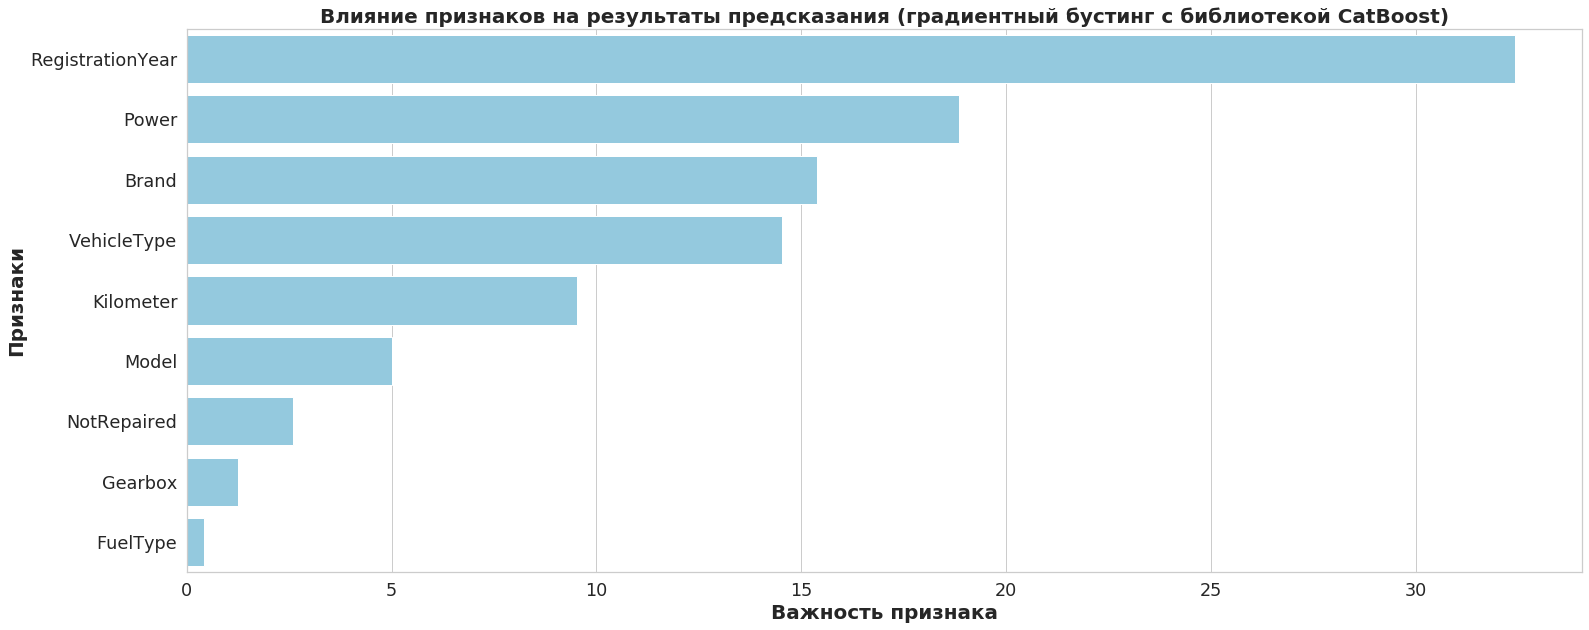

None

           Features  Importance
0  RegistrationYear   32.439698
1             Power   18.849641
2             Brand   15.378715
3       VehicleType   14.539638
4         Kilometer    9.534141
5             Model    5.001265
6       NotRepaired    2.592957
7           Gearbox    1.252587
8          FuelType    0.411357


(None, None)

In [73]:
# Определим влияние признаков на обучение модели с помошью ф-ии "feature_importance"
feature_importance(model_CBR, 'Влияние признаков на результаты предсказания (градиентный бустинг с библиотекой CatBoost)')

### Вывод по п.2.1

С помощью CatBoost модель обучается не долго, но подбор гиперпараметров занимает определенное время, с учетом большого количества гиперпараметров можно добится хорошей точности, но подбор большого количества гиперпараметров скорее всего потребует много ресурсов.  

<a id='2.2-bullet'></a>
### 2.2 Обучение модели с помощью градиентного бустинга с библиотекой LightGBM

In [74]:
# Обучим модель с помощью градиентного бустинга (библиотека LightGBM) 
#start_time_LGB = time.time()
#model_LGB = LGBMRegressor(n_estimators = 600, max_depth=10, learning_rate = 0.05)

#rmse_score = make_scorer(rmse)
#cv_LGB = cross_val_score(model_LGB, features_train, target_train, scoring=rmse_score, cv=3)
#RMSE_LGB = cv_LGB.mean()
#end_time_LGB = time.time()
#learning_time_LGB = round(((end_time_LGB - start_time_LGB)/60), 2) 

#print(cv_LGB)
#print('Время обучения модели: ', learning_time_LGB, 'мин')
#print('Метрика RMSE: ', RMSE_LGB)

In [75]:
# Укажем модели категориальные признаки
features_train_LGB = features_train.astype({'VehicleType': 'category', 'Gearbox': 'category', 'Model': 'category', 
                                        'FuelType': 'category', 'Brand': 'category', 'NotRepaired': 'category'})
features_test_LGB = features_test.astype({'VehicleType': 'category', 'Gearbox': 'category', 'Model': 'category', 
                                        'FuelType': 'category', 'Brand': 'category', 'NotRepaired': 'category'})

In [76]:
# С помощью GridSearch найдем оптимальные гиперпараметры
# (!!! интервалы гиперпараметров специально уменьшил, что бы jupyter не зависал при проверке)
param_LGB = {'n_estimators' : range(400, 450, 50), 
             'max_depth' : range(8, 10, 1), 
             'learning_rate' : [0.001]
             }

gs_LGB = GridSearchCV(LGBMRegressor(), param_LGB, cv=3)
gs_LGB.fit(features_train_LGB, target_train)
print(gs_LGB.best_params_)

{'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 400}


In [77]:
# Обучим модель с помощью градиентного бустинга (библиотека LightGBM) 
start_time_LGB = time.time()
model_LGB = LGBMRegressor(n_estimators = 400, max_depth=8, learning_rate = 0.05)
model_LGB.fit(features_train_LGB, target_train)
end_time_LGB = time.time()

learning_time_LGB = round(((end_time_LGB - start_time_LGB)/60), 2) 

print('Время обучения модели: ', learning_time_LGB, 'мин')

Время обучения модели:  0.51 мин


In [78]:
start_predict_time_LGB = time.time()
prediction_LGB = model_LGB.predict(features_test_LGB)
RMSE_LGB = rmse(target_test, prediction_LGB)
end_predict_time_LGB = time.time()

predict_time_LGB = round(((end_predict_time_LGB - start_predict_time_LGB)/60), 2) 

print('Время предсказания модели: ', predict_time_LGB, 'мин')
print('Метрика RMSE: ', RMSE_LGB)

Время предсказания модели:  0.08 мин
Метрика RMSE:  1609.2108109066062


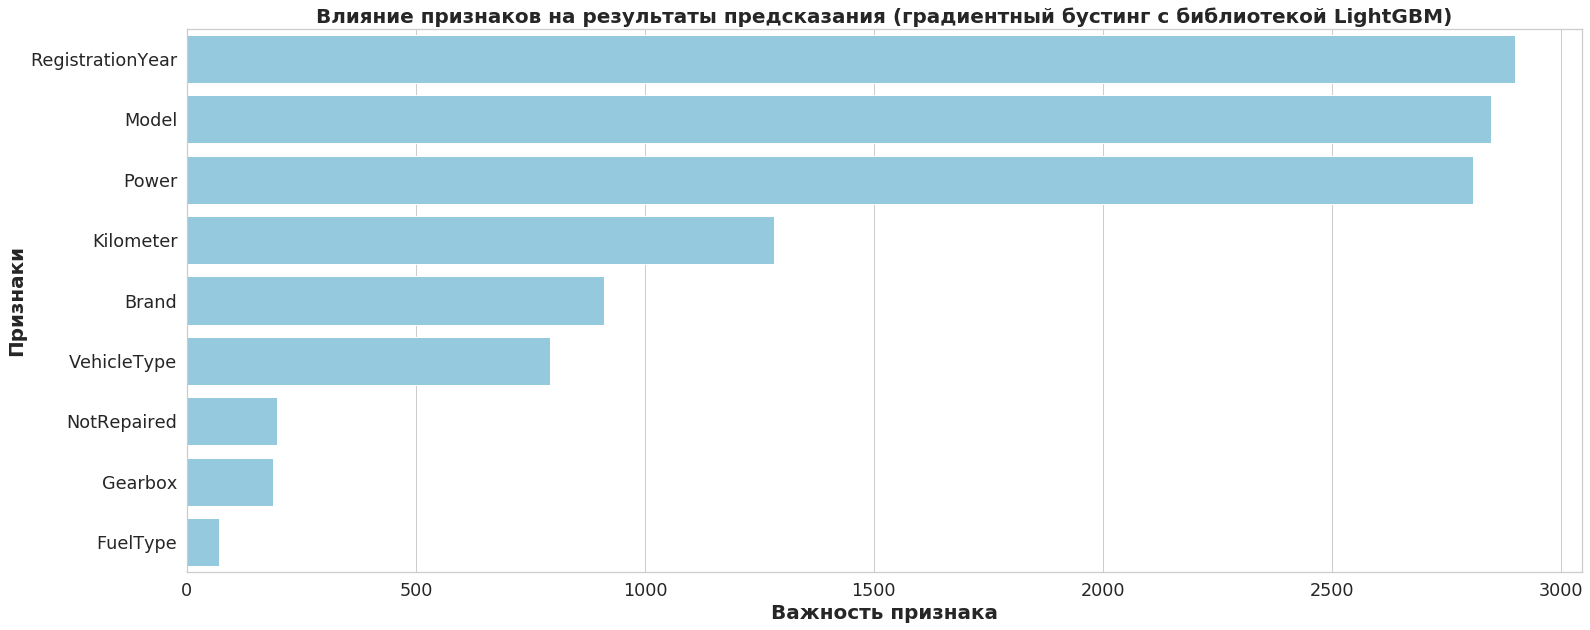

None

           Features  Importance
0  RegistrationYear        2901
1             Model        2848
2             Power        2808
3         Kilometer        1283
4             Brand         910
5       VehicleType         793
6       NotRepaired         197
7           Gearbox         189
8          FuelType          71


(None, None)

In [79]:
# Определим влияние признаков на обучение модели с помошью ф-ии "feature_importance"
feature_importance(model_LGB, 'Влияние признаков на результаты предсказания (градиентный бустинг с библиотекой LightGBM)')

### Вывод по п.2.2

С помощью LightGBM при нескольких гиперпараметрах модель обучается быстро, но увеличение количества гиперпараметров и их изменения по отношению к дефолтным настройкам существенно увеличивают время обучения 

<a id='2.3-bullet'></a>
### 2.3 Обучение модели с помощью случайного леса

In [80]:
# Выполним порядковое кодирование текстовых параметров c помощью OrdinalEncoder
text_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
    
encoder = OrdinalEncoder()
encoder.fit(features_train[text_features])
features_train[text_features] = encoder.transform(features_train[text_features])
features_test[text_features] = encoder.transform(features_test[text_features])
features_test.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
284346,1.0,2005,0.0,333,18.0,150000,6.0,2.0,0.0
179109,7.0,2007,1.0,149,29.0,150000,6.0,1.0,0.0
154866,7.0,1997,1.0,105,42.0,150000,6.0,24.0,0.0
30827,0.0,2002,1.0,118,213.0,150000,6.0,20.0,0.0
234996,2.0,2001,1.0,115,10.0,150000,4.0,25.0,0.0


In [81]:
# С помощью GridSearch найдем оптимальные гиперпараметры 
# (!!! интервалы гиперпараметров специально уменьшил, что бы jupyter не зависал при проверке)
param_RF = {'max_depth' : range(20, 25, 5), 
             'n_estimators' : range(5, 10, 1)
            }

gs_RF = GridSearchCV(RandomForestRegressor(), param_RF, cv=3)
gs_RF.fit(features_train, target_train)
print(gs_RF.best_params_)

{'max_depth': 20, 'n_estimators': 9}


In [82]:
# Обучим модель с выборанными гиперпераметрами 
start_time_RF = time.time()
model_RF = RandomForestRegressor(random_state=12345, max_depth=20, n_estimators=9)
model_RF.fit(features_train, target_train)
end_time_RF = time.time()

learning_time_RF = round(((end_time_RF - start_time_RF)/60), 2) 

print('Время обучения модели: ', learning_time_RF, 'мин')


Время обучения модели:  0.09 мин


In [83]:
start_predict_time_RF = time.time()
prediction_RF = model_RF.predict(features_test)
RMSE_RF = rmse(target_test, prediction_RF)
end_predict_time_RF = time.time()
                          
predict_time_RF = round(((end_predict_time_RF - start_predict_time_RF)/60), 2) 

print('Время предсказания модели: ', predict_time_RF, 'мин')
print('Метрика RMSE: ', RMSE_RF)

Время предсказания модели:  0.0 мин
Метрика RMSE:  1647.8479665197326


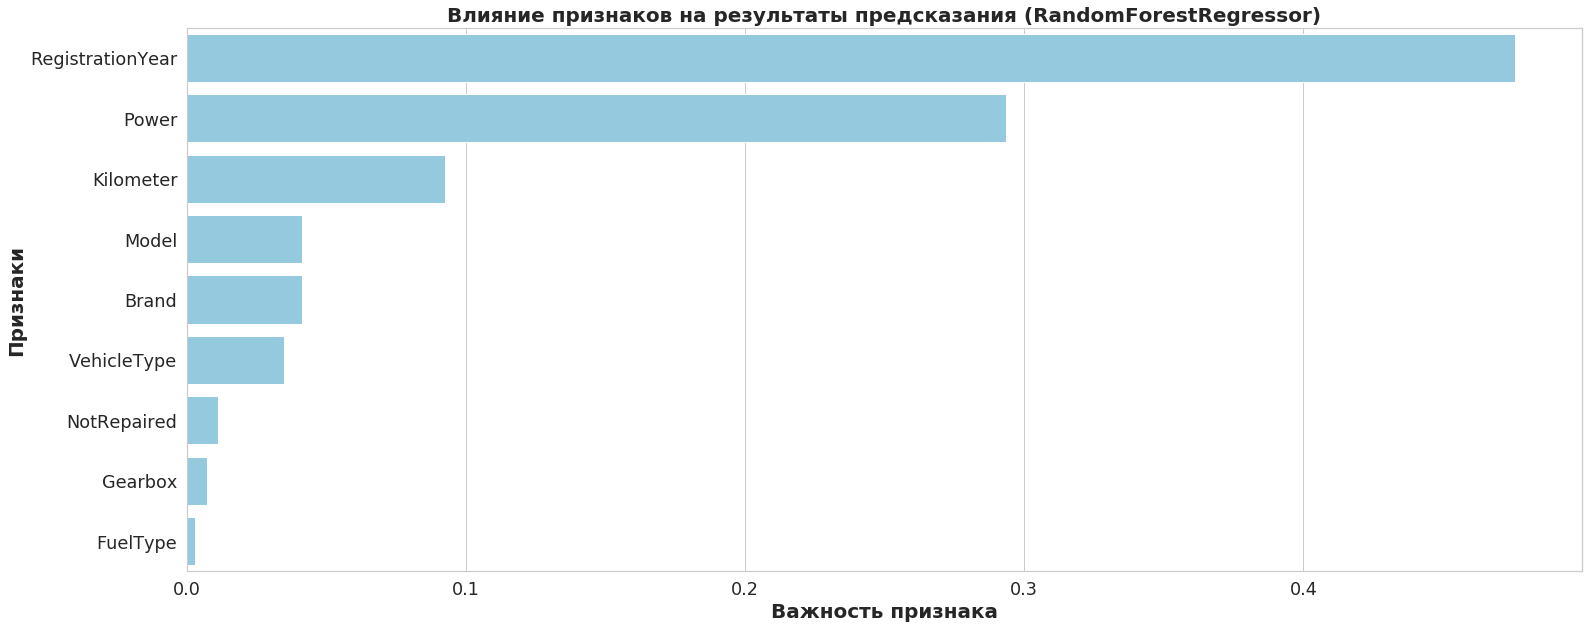

None

           Features  Importance
0  RegistrationYear    0.475988
1             Power    0.293373
2         Kilometer    0.092508
3             Model    0.041122
4             Brand    0.041060
5       VehicleType    0.034896
6       NotRepaired    0.011126
7           Gearbox    0.007183
8          FuelType    0.002743


(None, None)

In [84]:
# Определим влияние признаков на обучение модели с помошью ф-ии "feature_importance"
feature_importance(model_RF, 'Влияние признаков на результаты предсказания (RandomForestRegressor)')

### Вывод по п. 2.3

Для обучения моделей с помощью **Решающего дерева и Случайного леса** текстовые признаки в выборках **features_train и features_test** были закодированы методом `OrdinalEncoder`.

С помощью Решеющего дерева модель обучается очень быстро но при изменении гиперпараметров нельзя существенно улучшить полученное качество модели.

<a id='2.4-bullet'></a>
### 2.4 Обучение модели с помощью решающего дерева

In [85]:
# С помощью GridSearch найдем оптимальные гиперпараметры
# (!!! интервалы гиперпараметров специально уменьшил, что бы jupyter не зависал при проверке)
param_DT = {'max_depth' : range(60, 100, 5), 
            'min_samples_leaf' : range(8, 10, 1),
           }

gs_DT = GridSearchCV(DecisionTreeRegressor(), param_DT, cv=3)
gs_DT.fit(features_train, target_train)
print(gs_DT.best_params_)

{'max_depth': 85, 'min_samples_leaf': 8}


In [86]:
# Обучим модель с выборанными гиперпераметрами 
start_time_DT = time.time()
model_DT = DecisionTreeRegressor(random_state=12345, max_depth=65, min_samples_leaf=8)
model_DT.fit(features_train, target_train)
end_time_DT = time.time()

learning_time_DT = round(((end_time_DT - start_time_DT)/60), 2) 

print('Время предсказания модели: ', learning_time_DT, 'мин')

Время предсказания модели:  0.01 мин


In [87]:
start_predict_time_DT = time.time()
prediction_DT = model_DT.predict(features_test)
RMSE_DT = rmse(target_test, prediction_DT)
end_predict_time_DT = time.time()

predict_time_DT = round(((end_predict_time_DT - start_predict_time_DT)/60), 2) 

print('Время обучения модели: ', predict_time_DT, 'мин')
print('Метрика RMSE: ', RMSE_DT)

Время обучения модели:  0.0 мин
Метрика RMSE:  1750.3944707764176


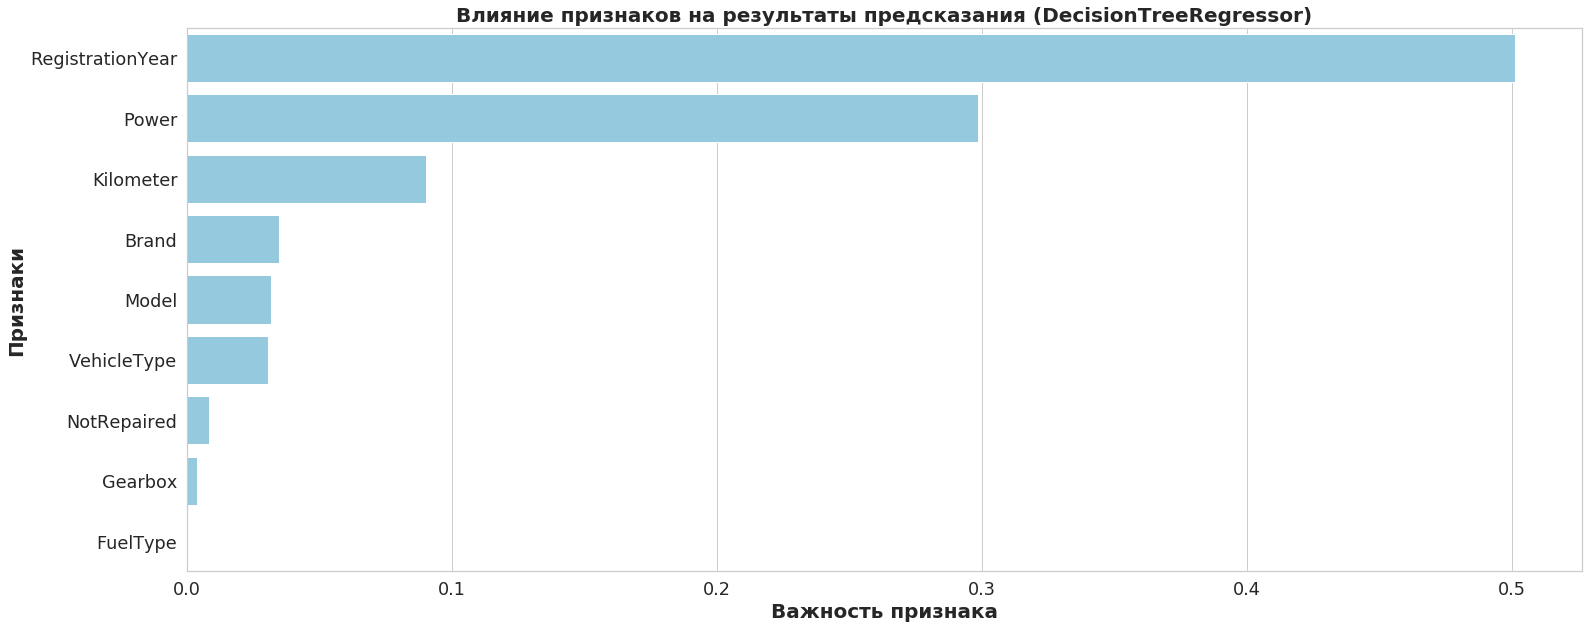

None

           Features  Importance
0  RegistrationYear    0.501329
1             Power    0.298527
2         Kilometer    0.090268
3             Brand    0.034907
4             Model    0.031552
5       VehicleType    0.030705
6       NotRepaired    0.008517
7           Gearbox    0.003878
8          FuelType    0.000317


(None, None)

In [88]:
# Определим влияние признаков на обучение модели с помошью ф-ии "feature_importance"
feature_importance(model_DT,'Влияние признаков на результаты предсказания (DecisionTreeRegressor)')

### Вывод по п.2.4

С помощью Случайного леса модель обучается очень быстро, но качество модели минимально меняется при изменении гиперпараметров. При существенном увеличении гиперпараметров (в 10 и 100 раз) улучшить качество не удалось 

<a id='3-bullet'></a>
# 3. Анализ моделей

In [89]:
# Соберем метрики моделей и время их обучения в таблицу для сравнения полученных результатов по каждой модели.
rmse_mertcs = {'CatBoost':[RMSE_CBR, learning_time_CBR, predict_time_CBR],
              'LightGBM':[RMSE_LGB, learning_time_LGB, predict_time_LGB],
              'RandomForestRegressor':[RMSE_RF, learning_time_RF, predict_time_RF],
               'DecisionTreeRegressor':[RMSE_DT, learning_time_DT, predict_time_DT]
              }
all_models = pd.DataFrame.from_dict(rmse_mertcs, orient='index', columns=['RMSE', 'Время обучения', 'Время предсказания'])
all_models

,RMSE,Время обучения,Время предсказания
CatBoost,1662.755017,7.73,0.01
LightGBM,1609.210811,0.51,0.08
RandomForestRegressor,1647.847967,0.09,0.00
DecisionTreeRegressor,1750.394471,0.01,0.00


<a id='4-bullet'></a>
# 4. Общие выводы

По соотношению качество модели, простота настройки обучения и скорость обучения лучше всего показала себя модель обученная с помощью **Случайного леса**. Данная модель достаточно быстро обучается и качество модели не значительно изменяется при применении гиперпараметров. При наличае большего времени на обучение и более производительного компьютера лучше воспользоваться моделью обученной с помощью **LightGBM**, она более чувствительна к изменению гиперпараметров и большое количество гиперпараметров существенно замедляет обучение, зато можно получить более точные результаты. 

Интересно, что одни и теже параметры имеют разный вес при обучение разных моделей. Основные параметры влияющие на обучение - **RegistrationYear и Power**, далее последовательность параметров отличается, причем для всех моделей самый важный параметр - **RegistrationYear**.
Три наименее весомых параметра совпадают у всех моделей - **NotRepaired, Gearbox, FuelType**

Использование той той или иной модели зависит от цели заказчика. Если необходимо быстро, но не очень точно определить стоимость по исходным данным тогда заказчику можно порекомендовать модель бученную с помощью **Случайного леса**. Если заказчику важнее точность предсказания, а время затраченное на выполнения предсказания не так важно, в этом случае эффективнее будет модель обученная с помощью **LightGBM**.